In [1]:
import os
import pandas as pd

# datahub path
if os.path.exists("/uss/hdsi-prismdata/q1-ucsd-inflows.pqt"):
    inflows_path = "/uss/hdsi-prismdata/q1-ucsd-inflows.pqt"
    outflows_path = "/uss/hdsi-prismdata/q1-ucsd-outflows.pqt"
    
# local path
else:
    inflows_path  = r"C:\Users\kangy\dsc180a-prism-data\data\q1-ucsd-inflows.parquet"
    outflows_path = r"C:\Users\kangy\dsc180a-prism-data\data\q1-ucsd-outflows.parquet"
    
inflows = pd.read_parquet(inflows_path)
outflows = pd.read_parquet(outflows_path)

inflows['posted_date'] = pd.to_datetime(inflows['posted_date'], errors='coerce') # fix datetime types

inflows['category'] = inflows['category'].replace('PAYCHECK_PLACEHOLDER', 'PAYCHECK') # Combine paycheck and paycheck_placeholder
inflows['memo'] = inflows['memo'].replace('PAYCHECK_PLACEHOLDER', 'PAYCHECK')
inflows

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-07-29,EXTERNAL_TRANSFER
...,...,...,...,...,...,...
513110,5941,acc_9524,EXTERNAL_TRANSFER,8.66,2023-01-21,EXTERNAL_TRANSFER
513111,5941,acc_9524,EXTERNAL_TRANSFER,267.13,2023-01-23,EXTERNAL_TRANSFER
513112,5941,acc_9524,EXTERNAL_TRANSFER,2.00,2023-01-24,EXTERNAL_TRANSFER
513113,5941,acc_9524,EXTERNAL_TRANSFER,207.16,2023-01-24,EXTERNAL_TRANSFER


## 1) Consumer Level Statistics

Calculate some statistics on the sample at the consumer level (transactions per consumer, sum of inflows per consumer)

In [2]:
# Consumer transaction volume and inflow amount statistics
consumer_stats = (
    inflows
    .groupby('prism_consumer_id')
    .agg(
        transac_count     = ('amount', 'size'),   
        total_amount  = ('amount', 'sum'),    
        mean_inflow   = ('amount', 'mean'),  
        std_inflow    = ('amount', 'std')     
    )
    .reset_index()
)

consumer_stats.head()

,prism_consumer_id,transac_count,total_amount,mean_inflow,std_inflow
0,0,91,110312.43,1212.224505,3938.620347
1,2,113,349639.03,3094.150708,18144.509122
2,4,152,462557.90,3043.144079,3526.443713
3,7,129,250214.09,1939.644109,3063.197693
4,9,375,215342.01,574.245360,1139.614461


In [3]:
# transac_count stats
print(consumer_stats['transac_count'].agg(['count','mean','std','min','max']))

# total_amount stats
print(consumer_stats['total_amount'].agg(['count','mean','std','min','max']))

count    2974.000000
mean      172.533625
std       148.452108
min         1.000000
max      1765.000000
Name: transac_count, dtype: float64
count    2.974000e+03
mean     1.267604e+05
std      3.005366e+05
min      2.400000e-01
max      1.032516e+07
Name: total_amount, dtype: float64


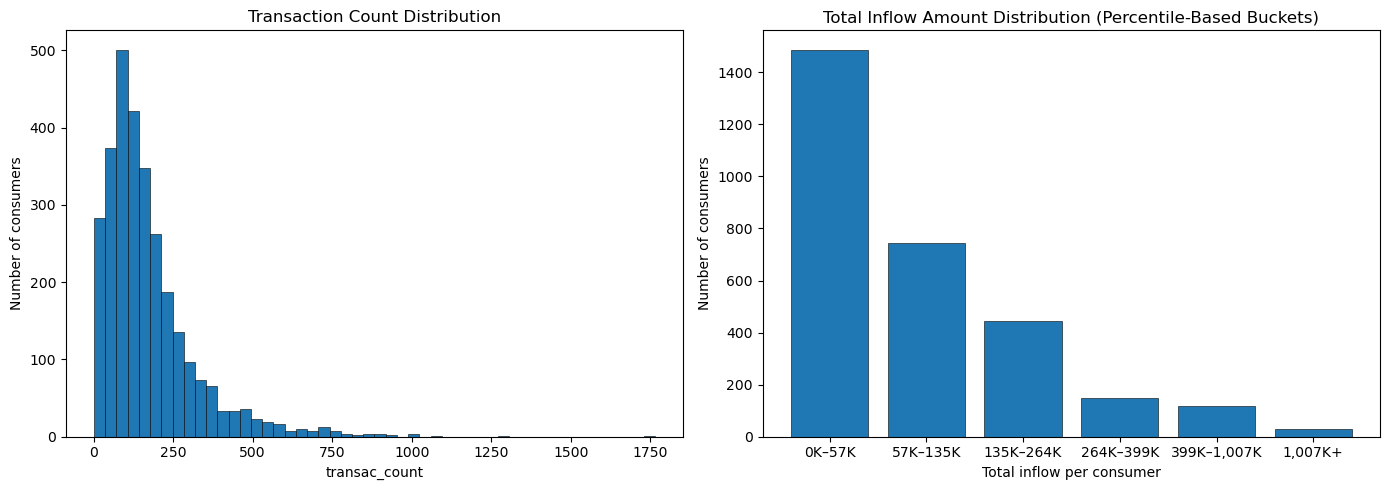

In [4]:
# Plot transaction-count distribution + percentile-based numeric buckets for total_amount

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ------------------------------------------------------------
# LEFT PLOT — Transaction Count Distribution (raw)
# ------------------------------------------------------------
axes[0].hist(
    consumer_stats['transac_count'],
    bins=50,
    edgecolor='black',
    linewidth=0.4
)
axes[0].set_title('Transaction Count Distribution')
axes[0].set_xlabel('transac_count')
axes[0].set_ylabel('Number of consumers')

# ------------------------------------------------------------
# RIGHT PLOT — Total Inflow Distribution using percentile-based numeric buckets
# ------------------------------------------------------------

# 1. percentile cut points for total_amount
q = consumer_stats['total_amount'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])

# 2. create numeric bin edges: 0 → each percentile → max
bins = [0] + list(q.values) + [consumer_stats['total_amount'].max()]
bins = np.unique(bins)

# 3. create readable bucket labels (in thousands)
labels = []
for i in range(len(bins) - 1):
    lo = bins[i] / 1000
    hi = bins[i + 1] / 1000
    if i == len(bins) - 2:
        label = f'{lo:,.0f}K+'
    else:
        label = f'{lo:,.0f}K–{hi:,.0f}K'
    labels.append(label)

# 4. assign bucket to each consumer
consumer_stats['amt_bucket'] = pd.cut(
    consumer_stats['total_amount'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 5. count consumers per bucket
bucket_counts = consumer_stats['amt_bucket'].value_counts().sort_index()

# 6. plot bucket bar chart
axes[1].bar(bucket_counts.index.astype(str), bucket_counts.values, edgecolor='black', linewidth=0.4)
axes[1].set_title('Total Inflow Amount Distribution (Percentile-Based Buckets)')
axes[1].set_xlabel('Total inflow per consumer')
axes[1].set_ylabel('Number of consumers')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()


How buckets were computed:
1. 50th, 75th, 90th, 95th, and 99th percentiles.
2. Use these percentile values as boundary points.
3. Convert these boundaries to value ranges.

In [5]:
# Calculate each consumer’s activity window and duration
temporal = (
    inflows
    .sort_values(['prism_consumer_id', 'posted_date'])
    .groupby('prism_consumer_id')
    .agg(
        first_date = ('posted_date', 'min'),
        last_date  = ('posted_date', 'max')
    )
    .assign(
        active_days = lambda x: (x['last_date'] - x['first_date']).dt.days
    )
    .reset_index()
)

temporal.head()

,prism_consumer_id,first_date,last_date,active_days
0,0,2022-02-14,2023-02-03,354
1,2,2020-12-07,2021-12-02,360
2,4,2022-02-02,2023-01-30,362
3,7,2022-05-06,2023-04-21,350
4,9,2018-10-12,2021-07-14,1006


In [6]:
# active_days stats
temporal['active_days'].agg(['count', 'mean', 'std', 'min', 'max'])

count    2974.000000
mean      319.393746
std       196.696371
min         0.000000
max      1758.000000
Name: active_days, dtype: float64

*Check the major source of inflows*

In [7]:
income_by_category = inflows.groupby('category')['amount'].agg(['sum', 'count', 'mean'])
income_by_category = income_by_category.sort_values('sum', ascending=False)
income_by_category['percentage'] = (income_by_category['sum'] / income_by_category['sum'].sum() * 100)
print("Inflow stats by category:")
print(income_by_category)
print()

Inflow stats by category:
                               sum   count         mean  percentage
category                                                           
PAYCHECK               89724682.02   59225  1514.979857   23.800566
EXTERNAL_TRANSFER      81586232.14  156533   521.207874   21.641743
DEPOSIT                66602343.60   61345  1085.701257   17.667084
MISCELLANEOUS          52594312.59   55648   945.124939   13.951283
SELF_TRANSFER          48301522.92  110437   437.367213   12.812568
OTHER_BENEFITS         12175837.46    7708  1579.636412    3.229789
INVESTMENT_INCOME       6887278.35   17325   397.534104    1.826935
TAX                     5619601.78    3405  1650.396999    1.490668
REFUND                  5406440.27   23220   232.835498    1.434124
LOAN                    4231710.73    2513  1683.927867    1.122513
SMALL_DOLLAR_ADVANCE    1906595.47   13621   139.974706    0.505748
UNEMPLOYMENT_BENEFITS   1610419.79    1961   821.223758    0.427183
INSURANCE             

## 2) What are the major sources of income?

In [8]:
inflows['memo'].value_counts()

memo
EXTERNAL_TRANSFER        156533
SELF_TRANSFER            110437
DEPOSIT                   61345
PAYCHECK                  59225
MISCELLANEOUS             55648
REFUND                    23220
INVESTMENT_INCOME         17325
SMALL_DOLLAR_ADVANCE      13621
OTHER_BENEFITS             7708
TAX                        3405
LOAN                       2513
UNEMPLOYMENT_BENEFITS      1961
INSURANCE                   174
Name: count, dtype: int64

In [9]:
# pick only income columns
income_cats = ['PAYCHECK','INVESTMENT_INCOME','OTHER_BENEFITS','UNEMPLOYMENT_BENEFITS']
income_df = inflows[inflows['memo'].isin(income_cats)]

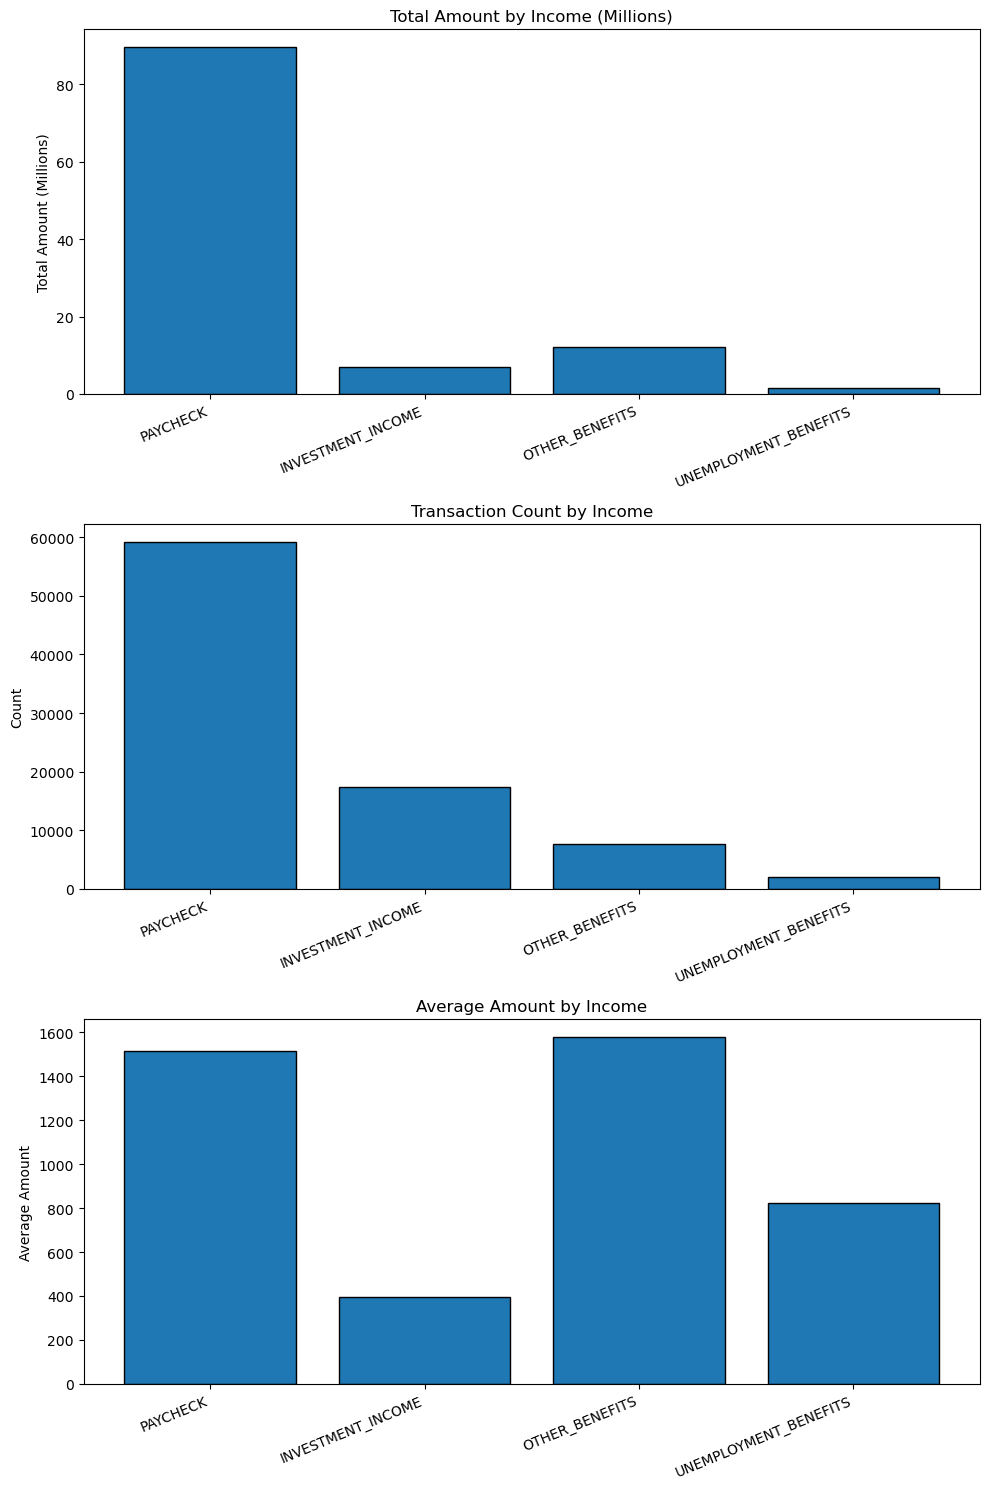

In [10]:
# compute all metrics
totals_millions = income_df.groupby('memo')['amount'].sum().reindex(income_cats) / 1_000_000
counts = income_df['memo'].value_counts().reindex(income_cats)
avg_amount = income_df.groupby('memo')['amount'].mean().reindex(income_cats)

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# 1. Total amount (millions)
axes[0].bar(range(len(totals_millions)), totals_millions.values, edgecolor='black')
axes[0].set_title('Total Amount by Income (Millions)')
axes[0].set_ylabel('Total Amount (Millions)')
axes[0].set_xticks(range(len(totals_millions)))
axes[0].set_xticklabels(totals_millions.index, rotation=22.5, ha='right')

# 2. Transaction count
axes[1].bar(range(len(counts)), counts.values, edgecolor='black')
axes[1].set_title('Transaction Count by Income')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(counts)))
axes[1].set_xticklabels(counts.index, rotation=22.5, ha='right')

# 3. Average amount
axes[2].bar(range(len(avg_amount)), avg_amount.values, edgecolor='black')
axes[2].set_title('Average Amount by Income')
axes[2].set_ylabel('Average Amount')
axes[2].set_xticks(range(len(avg_amount)))
axes[2].set_xticklabels(avg_amount.index, rotation=22.5, ha='right')

plt.tight_layout()

In [11]:
# summary table of graphs
summary = pd.DataFrame({
    'total_amount_millions': totals_millions,
    'count': counts,
    'avg_amount': avg_amount
})

summary

,total_amount_millions,count,avg_amount
memo,,,
PAYCHECK,89.724682,59225,1514.979857
INVESTMENT_INCOME,6.887278,17325,397.534104
OTHER_BENEFITS,12.175837,7708,1579.636412
UNEMPLOYMENT_BENEFITS,1.610420,1961,821.223758


## 3) Measure "regular" paychecks, deposits, etc.

In [12]:
def find_regular_income(df, min_occurrences=3, amount_tolerance=0.15, day_tolerance=3, min_amount=50):
    """
    Identify regular income patterns (e.g., biweekly paychecks, monthly benefits).

    Parameters:
    - df: DataFrame with columns ['prism_consumer_id', 'amount', 'posted_date', 'category']
    - min_occurrences: Minimum number of transactions to consider a pattern
    - amount_tolerance: % variation allowed in amount (0.15 = 15%)
    - day_tolerance: Days of variation allowed in interval
    - min_amount: Minimum average amount for a group to be considered (default $50)

    Returns: DataFrame with regular income patterns
    """
    results = []

    for consumer_id in df['prism_consumer_id'].unique():
        consumer_df = df[df['prism_consumer_id'] == consumer_id].sort_values('posted_date')

        if len(consumer_df) < min_occurrences:
            continue

        # Group by similar amounts (within tolerance)
        consumer_df = consumer_df.copy()

        # Uses clustering to group by amount plus/minus the tolerance
        amounts = consumer_df['amount'].values
        labels = []
        cluster_means = []
        cluter_counts = []

        for amt in amounts:
            placed = False
            for cid, mean in enumerate(cluster_means):
                if abs(amt - mean) <= amount_tolerance * mean:
                    cluter_counts[cid] += 1
                    cluster_means[cid] = cluster_means[cid] + (amt - cluster_means[cid]) / cluter_counts[cid]
                    labels.append(cid)
                    placed = True
                    break
            if not placed:
                cluster_means.append(amt)
                cluter_counts.append(1)
                labels.append(len(cluster_means) - 1)

        consumer_df['amount_group'] = labels
        

        for amount_group, group_df in consumer_df.groupby('amount_group'):
            if len(group_df) < min_occurrences:
                continue

            # Calculate average amount and skip small amounts
            avg_amount = group_df['amount'].mean()
            if avg_amount < min_amount:
                continue

            # Calculate days between transactions
            group_df = group_df.copy()
            group_df['days_diff'] = group_df['posted_date'].diff().dt.days

            mean_interval = group_df['days_diff'].mean()
            std_interval = group_df['days_diff'].std()

            # Skip if no valid interval or too irregular
            if pd.isna(mean_interval) or pd.isna(std_interval):
                continue

            # Avoid division by zero and guard against tiny mean_interval
            if mean_interval == 0:
                continue

            # Classify pattern type
            if 6 <= mean_interval <= 8 and std_interval <= day_tolerance:
                pattern = 'weekly'
            elif 13 <= mean_interval <= 15 and std_interval <= day_tolerance:
                pattern = 'biweekly'
            elif 27 <= mean_interval <= 33 and std_interval <= day_tolerance * 2:
                pattern = 'monthly'
            elif (std_interval / mean_interval) < 0.15:  # Low variation
                pattern = f'every_{int(round(mean_interval))}_days'
            else:
                continue

            results.append({
                'prism_consumer_id': consumer_id,
                'pattern': pattern,
                'category': group_df['category'].iloc[0],
                'avg_amount': avg_amount,
                'count': len(group_df),
                'avg_interval_days': mean_interval,
                'std_interval_days': std_interval
            })

    return pd.DataFrame(results)

# Apply to income data
regular_income = find_regular_income(income_df)
print(f"Found {len(regular_income)} regular income patterns for {regular_income['prism_consumer_id'].nunique()} consumers")
regular_income.head(10)

Found 1318 regular income patterns for 1046 consumers


,prism_consumer_id,pattern,category,avg_amount,count,avg_interval_days,std_interval_days
0,0,every_15_days,PAYCHECK,2456.337917,24,15.217391,1.346933
1,4,biweekly,PAYCHECK,5620.946923,26,14.000000,0.288675
2,12,monthly,OTHER_BENEFITS,1835.900000,12,29.909091,3.300138
3,13,biweekly,PAYCHECK,3472.353333,9,14.000000,0.000000
4,13,every_15_days,PAYCHECK,4349.827500,16,15.200000,1.373213
5,23,every_15_days,PAYCHECK,1350.000000,24,15.217391,1.204406
6,26,biweekly,PAYCHECK,2884.084000,5,14.000000,0.000000
7,29,monthly,OTHER_BENEFITS,1519.750000,12,29.909091,3.269696
8,32,monthly,PAYCHECK,1794.308750,8,30.000000,5.291503
9,34,biweekly,PAYCHECK,1381.853333,12,14.000000,0.000000


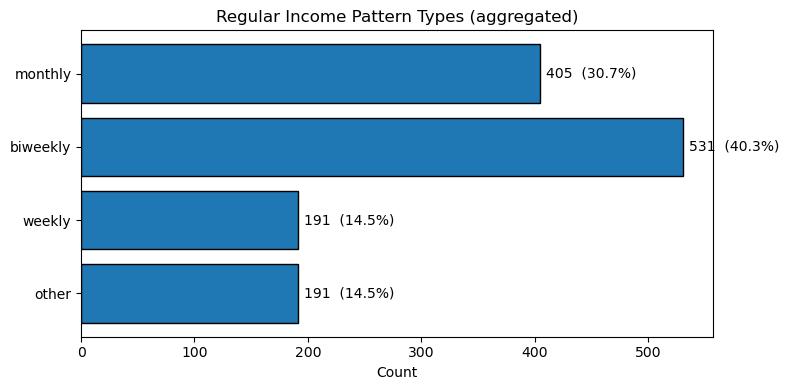

In [13]:
# Visualize regular income patterns
import matplotlib.pyplot as plt

pattern_counts = regular_income['pattern'].value_counts()
primary = ['monthly', 'biweekly', 'weekly']
primary_counts = pattern_counts.reindex(primary).fillna(0)
other_count = pattern_counts.drop(primary).sum()
combined = pd.Series(data=list(primary_counts) + [other_count], index=primary + ['other'])
combined_pct = combined / combined.sum() * 100

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(range(len(combined)), combined.values, edgecolor='black', color='tab:blue')
ax.set_yticks(range(len(combined)))
ax.set_yticklabels(combined.index)
ax.set_title('Regular Income Pattern Types (aggregated)')
ax.set_xlabel('Count')
ax.invert_yaxis()

# Annotate counts + percentages
max_val = combined.values.max() if len(combined) > 0 else 0
for i, (count, pct) in enumerate(zip(combined.values, combined_pct.values)):
    ax.text(count + max_val * 0.01, i, f"{int(count)}  ({pct:.1f}%)", va='center')

plt.tight_layout()
plt.show()

In [14]:
# Summary statistics
print(f"Total regular patterns found: {len(regular_income)}")
print(f"Consumers with regular income: {regular_income['prism_consumer_id'].nunique()}")
print(f"Percentage of income consumers: {regular_income['prism_consumer_id'].nunique() / income_df['prism_consumer_id'].nunique() * 100:.1f}%\n")


Total regular patterns found: 1318
Consumers with regular income: 1046
Percentage of income consumers: 39.2%

